In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Packages and imports

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import torch

In [ ]:
!pip install torch_geometric -q
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 12.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.8 MB/s eta 0:00:00


Visualize function

In [ ]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def visualize(h, color):
    z = PCA(n_components=2).fit_transform(h.cpu().detach().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color)
    plt.show()

# Graph

## Edges

In [ ]:
edges = pd.read_csv('/content/drive/MyDrive/TAI/III/gnn/data/twitch_gamers/large_twitch_edges.csv')
edges

,numeric_id_1,numeric_id_2
0,98343,141493
1,98343,58736
2,98343,140703
3,98343,151401
4,98343,157118
...,...,...
6797552,97507,29359
6797553,71175,12020
6797554,151702,128281
6797555,118034,38021


## Create graph

In [ ]:
G = nx.from_pandas_edgelist(edges, source='numeric_id_1', target='numeric_id_2')
print(G)

Graph with 168114 nodes and 6797557 edges


### Degree embeddings

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch

# using degree as embedding
degree = np.array(list(dict(G.degree()).values()))

# normalizing degree values
scale = StandardScaler()
degree = scale.fit_transform(degree.reshape(-1,1))

## Nodes

In [ ]:
nodes = pd.read_csv('/content/drive/MyDrive/TAI/III/gnn/data/twitch_gamers/large_twitch_features.csv')
nodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168114 entries, 0 to 168113
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   views         168114 non-null  int64 
 1   mature        168114 non-null  int64 
 2   life_time     168114 non-null  int64 
 3   created_at    168114 non-null  object
 4   updated_at    168114 non-null  object
 5   numeric_id    168114 non-null  int64 
 6   dead_account  168114 non-null  int64 
 7   language      168114 non-null  object
 8   affiliate     168114 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 11.5+ MB


### Create features

In [ ]:
nodes.created_at = pd.to_datetime(nodes.created_at)
nodes.updated_at = pd.to_datetime(nodes.updated_at)
nodes = nodes.drop(columns=['created_at', 'updated_at'])
nodes["degree"] = degree
nodes['language'] = pd.Categorical(nodes['language'], categories=nodes['language'].unique()).codes

## Normalization

MinMax Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
# normalizing degree values
scale = StandardScaler()
nodes['views'] = scale.fit_transform(nodes['views'].values.reshape(-1,1))
nodes['life_time'] = scale.fit_transform(nodes['life_time'].values.reshape(-1,1))

nodes['language'] = scale.fit_transform(nodes['language'].values.reshape(-1,1))

## Set index

In [ ]:
nodes = nodes.set_index(['numeric_id'])

## Final nodes dataframe

In [ ]:
nodes

,views,mature,life_time,dead_account,language,affiliate,degree
numeric_id,,,,,,,
0,-0.054202,1,-0.800350,0,-0.472409,1,-0.133270
1,-0.056421,0,1.616857,0,-0.472409,0,13.926364
2,0.058429,1,2.245610,0,-0.472409,1,1.079481
3,-0.056455,0,-0.276389,0,-0.472409,0,0.512894
4,-0.055824,0,0.338392,0,-0.472409,0,0.490612
...,...,...,...,...,...,...,...
168109,-0.055078,0,-1.022510,0,-0.472409,0,-0.254227
168110,-0.055330,1,0.751972,0,-0.472409,0,-0.254227
168111,-0.055505,0,0.356556,0,-0.472409,1,-0.254227


## Set target and features for training

In [ ]:
target = nodes.filter(like='mature').columns.tolist()
features = nodes.columns.difference(target, sort=False)

In [ ]:
print(target)
print(features.tolist())

['mature']
['views', 'life_time', 'dead_account', 'language', 'affiliate', 'degree']


In [ ]:
nodes

,views,mature,life_time,dead_account,language,affiliate,degree
numeric_id,,,,,,,
0,-0.054202,1,-0.800350,0,-0.472409,1,-0.133270
1,-0.056421,0,1.616857,0,-0.472409,0,13.926364
2,0.058429,1,2.245610,0,-0.472409,1,1.079481
3,-0.056455,0,-0.276389,0,-0.472409,0,0.512894
4,-0.055824,0,0.338392,0,-0.472409,0,0.490612
...,...,...,...,...,...,...,...
168109,-0.055078,0,-1.022510,0,-0.472409,0,-0.254227
168110,-0.055330,1,0.751972,0,-0.472409,0,-0.254227
168111,-0.055505,0,0.356556,0,-0.472409,1,-0.254227


# Dataset

In [ ]:
X = np.asarray(nodes[features].values)
y = np.asarray(nodes[target].values)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y = enc.fit_transform(y.reshape(-1, 1))

In [ ]:
np.unique(np.argmax(y, axis=1), return_counts=True)

(array([0, 1]), array([89081, 79033]))

## Class distribution

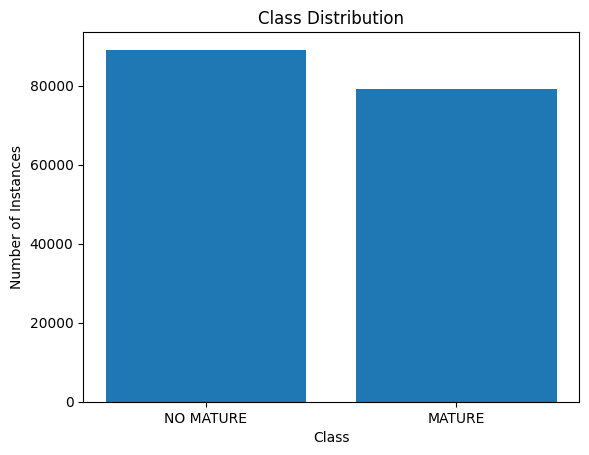

In [ ]:

import matplotlib.pyplot as plt

# class labels
labels = ['NO MATURE' , 'MATURE']

# number of instances for each class
instances = np.unique(np.argmax(y, axis=1), return_counts=True)[1]

# create bar chart
plt.bar(labels, instances)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.show()

## Compute class weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(np.argmax(y, axis=1)),
                                    y=np.argmax(y, axis=1))
list(class_weight)

[0.943601890414342, 1.0635683828274265]

## Edge index

In [ ]:
adj = nx.to_scipy_sparse_array(G).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64))
col = torch.from_numpy(adj.col.astype(np.int64))
edge_index = torch.stack([row, col], dim=0)

In [ ]:
print(X.shape)
print(y.shape)
print(edge_index.shape)

(168114, 6)
(168114, 2)
torch.Size([2, 13595114])


## Create dataset

In [ ]:

from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, InMemoryDataset, Dataset
from torch_geometric.loader import DataLoader

class CustomDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super(CustomDataset, self).__init__('.', transform, None, None)

        data = Data(edge_index=edge_index)
        data.x = torch.from_numpy(X).type(torch.float32)
        data.y = torch.from_numpy(y).type(torch.float32)
        data.num_classes = len(y[0])

        self.data, self.slices = self.collate([data])

## Dataset info

In [ ]:
dataset = CustomDataset()
data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Number of training nodes: {data.train_mask.sum()}')
# print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(edge_index=[2, 13595114], x=[168114, 6], y=[168114, 2], num_classes=2)
Number of nodes: 168114
Number of edges: 13595114
Average node degree: 80.87
Has isolated nodes: False
Has self-loops: False
Is undirected: True


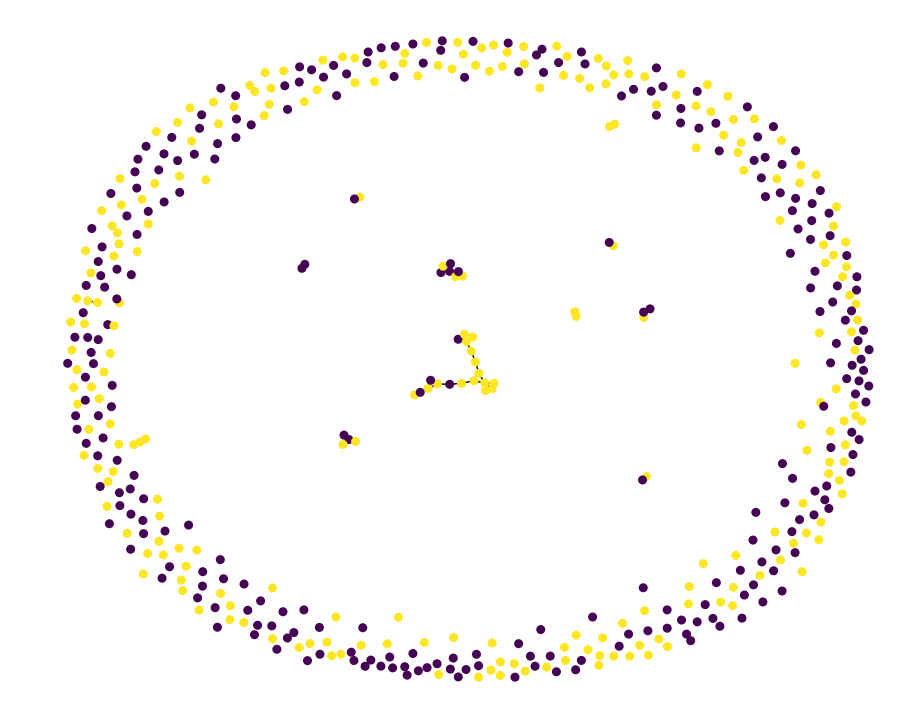

In [ ]:
import random
from torch_geometric.utils import to_networkx
import networkx as nx

n_sample = 500
y_enc = np.argmax(data.y.numpy(), axis=1)

sampled_nodes = np.random.choice(G.nodes, n_sample)
G_sub = G.subgraph(sampled_nodes)
y_sub = y_enc[G_sub.nodes]


plt.figure(figsize=(9, 7))
nx.draw_spring(G_sub, node_size=30, arrows=False, node_color=y_sub)
plt.show() 
    


In [ ]:
import torch_geometric.transforms as T

split = T.RandomNodeSplit(num_val=0.1,  num_test=0.2)
data = split(data)

In [ ]:
data

Data(edge_index=[2, 13595114], x=[168114, 6], y=[168114, 2], num_classes=2, train_mask=[168114], val_mask=[168114], test_mask=[168114])

# Models

In [ ]:
from torchmetrics import AUROC, Accuracy
def train_node_classifier(model, graph, optimizer, criterion, n_epochs=200):

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out, _ = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        acc, auc = eval_node_classifier(model, graph, graph.val_mask)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}, Val AUC: {auc:.3f}')

    return model


def eval_node_classifier(model, data, mask):

    model.eval()
    preds, _ = model(data)
    preds = preds[mask]
    trues = data.y.argmax(dim=1)[mask]
    accuracy = Accuracy(task="multiclass", num_classes=dataset.num_classes).to(device)
    acc = accuracy(preds.argmax(dim=1),  trues)

    auroc = AUROC(task="multiclass", num_classes=dataset.num_classes).to(device)
    auc = auroc(preds,  trues)
    return acc, auc
  

In [ ]:
def visualize_features(model, data, device, n):
  model.to(device)
  model.eval()
  data.to(device)

  _, features = model(data)
  y_enc = np.argmax(data.y.cpu().detach().numpy(), axis=1)
  visualize(features[:n], color=y_enc[:n])

Device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data.to(device)

Data(edge_index=[2, 13595114], x=[168114, 6], y=[168114, 2], num_classes=2, train_mask=[168114], val_mask=[168114], test_mask=[168114])

## MLP

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, 16)
        self.lin2 = Linear(16, dataset.num_classes)

    def forward(self, data):
        x = data.x
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5)
        x = self.lin2(x)

        return F.softmax(x, dim=1), x

mlp = MLP().to(device)
print(mlp)

MLP(
  (lin1): Linear(in_features=6, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=2, bias=True)
)


### Evaluate before training


In [ ]:
test_acc, test_auc = eval_node_classifier(mlp, data, data.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test auc: {test_auc:.3f}')

Test Acc: 0.478, Test auc: 0.482


### Visualization of the node embeddings before training

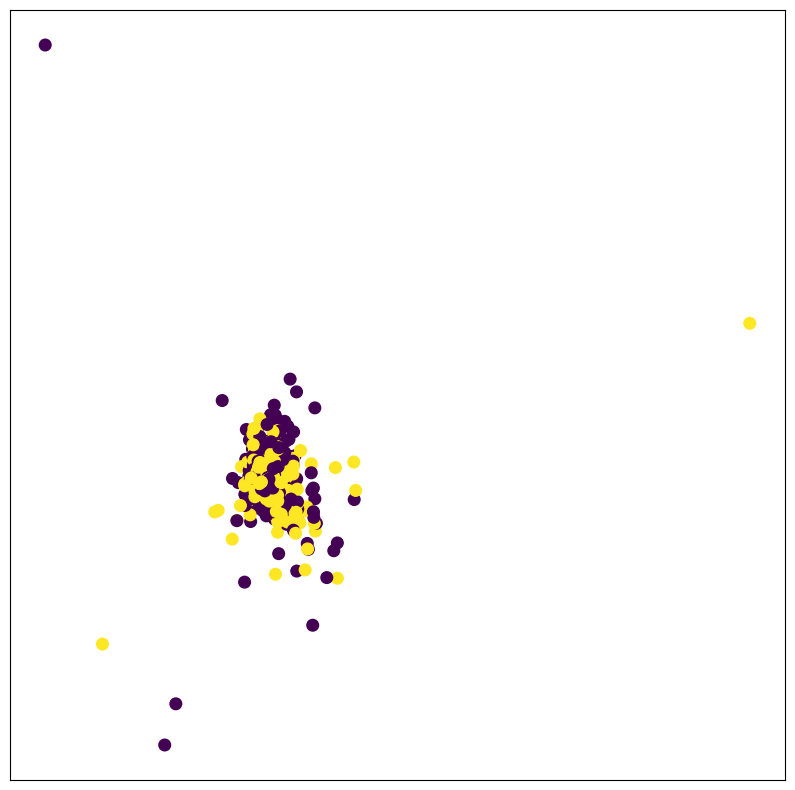

In [ ]:
visualize_features(mlp, data, device, 1000)

### Training

In [ ]:
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.1, weight_decay=5e-4)

class_weights = torch.FloatTensor(class_weight).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

mlp = train_node_classifier(mlp, data, optimizer, criterion, n_epochs=100)


Epoch: 010, Train Loss: 0.676, Val Acc: 0.570, Val AUC: 0.600
Epoch: 020, Train Loss: 0.674, Val Acc: 0.576, Val AUC: 0.599
Epoch: 030, Train Loss: 0.673, Val Acc: 0.582, Val AUC: 0.603
Epoch: 040, Train Loss: 0.673, Val Acc: 0.581, Val AUC: 0.607
Epoch: 050, Train Loss: 0.672, Val Acc: 0.580, Val AUC: 0.605
Epoch: 060, Train Loss: 0.673, Val Acc: 0.580, Val AUC: 0.604
Epoch: 070, Train Loss: 0.672, Val Acc: 0.582, Val AUC: 0.604
Epoch: 080, Train Loss: 0.672, Val Acc: 0.580, Val AUC: 0.604
Epoch: 090, Train Loss: 0.672, Val Acc: 0.583, Val AUC: 0.605
Epoch: 100, Train Loss: 0.672, Val Acc: 0.584, Val AUC: 0.604


### Evaluate after training


In [ ]:
test_acc, test_auc = eval_node_classifier(mlp, data, data.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test auc: {test_auc:.3f}')

Test Acc: 0.589, Test auc: 0.613


### Visualization of the node embeddings after training

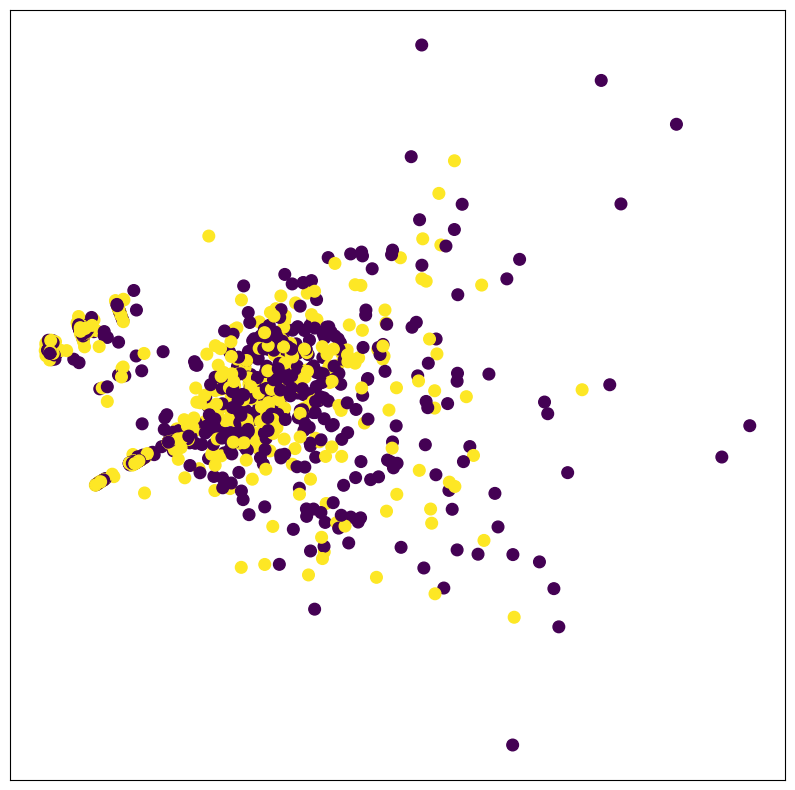

In [ ]:
visualize_features(mlp, data, device, 1000)

## GNN GCNConv

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.classifier = Linear(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.classifier(x)

        return F.softmax(x, dim=1), x

gcn = GCN().to(device)
print(gcn)

GCN(
  (conv1): GCNConv(6, 16)
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)


### Evaluate before training

In [ ]:
test_acc, test_auc = eval_node_classifier(gcn, data, data.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test auc: {test_auc:.3f}')

Test Acc: 0.529, Test auc: 0.488


### Visualization of the node embeddings before training

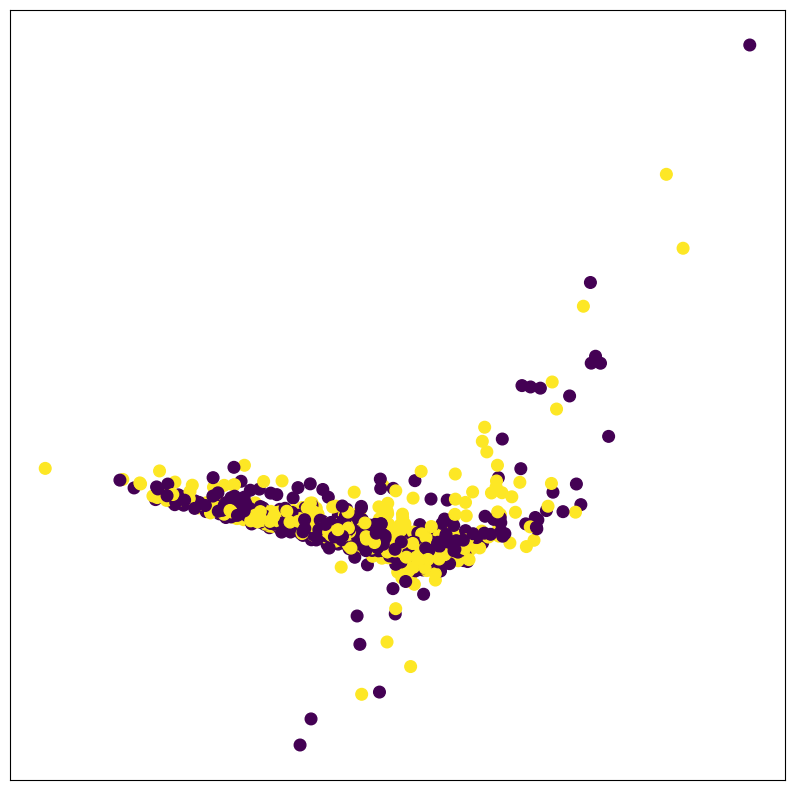

In [ ]:
visualize_features(gcn, data, device, 1000)

### Training

In [ ]:
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)

class_weights = torch.FloatTensor(class_weight).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

gcn = train_node_classifier(gcn, data, optimizer, criterion, n_epochs=100)


Epoch: 010, Train Loss: 0.693, Val Acc: 0.520, Val AUC: 0.520
Epoch: 020, Train Loss: 0.693, Val Acc: 0.510, Val AUC: 0.519


### Evaluate after training

In [ ]:
test_acc, test_auc = eval_node_classifier(gcn, data, data.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test auc: {test_auc:.3f}')

Test Acc: 0.513, Test auc: 0.524


### Visualization of the node embeddings after training

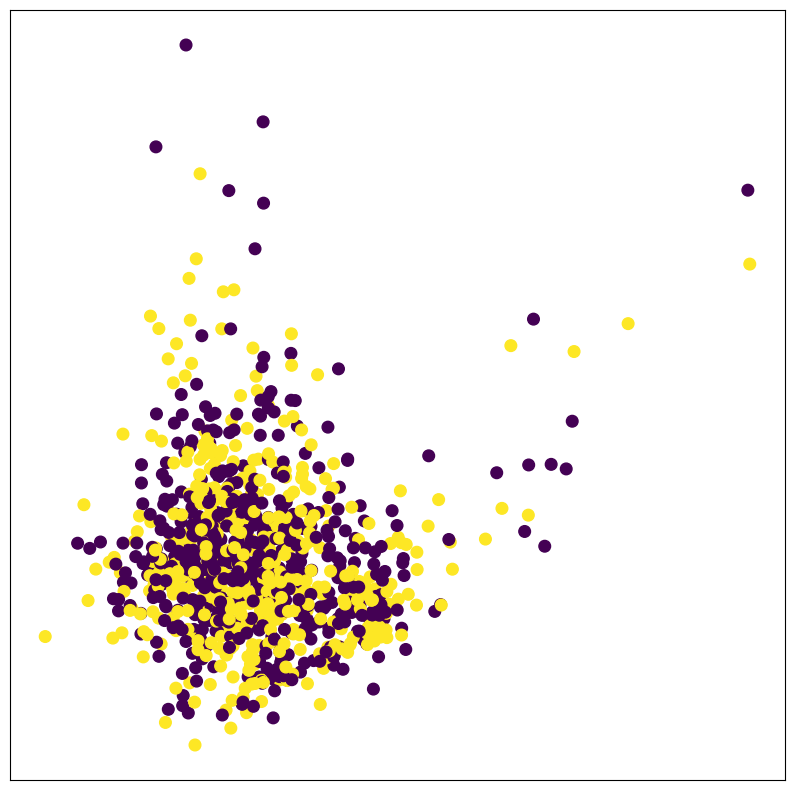

In [ ]:
visualize_features(gcn, data, device, 1000)